In [1]:
import os
import sys
import glob
from collections import defaultdict, Counter
from functools import reduce, partial
from multiprocessing import Pool
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import bootstrap, binom_test
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import cosine, euclidean
from Bio import SeqIO
import tqdm

from pymutspec.draw import plot_mutspec12, plot_mutspec192
from pymutspec.annotation import rev_comp, CodonAnnotation, transcriptor, mutations_summary, calculate_mutspec
from pymutspec.io import read_rates, GenesStates
from pymutspec.constants import possible_sbs192, possible_sbs12

%matplotlib inline

In [2]:
def complete_sbs192_columns(df: pd.DataFrame):
    df = df.copy()
    if len(df.columns) != 192:
        for sbs192 in set(possible_sbs192).difference(df.columns.values):
            df[sbs192] = 0.
    df = df[possible_sbs192]
    return df


def jackknife_spectra_sampling(obs: pd.DataFrame, exp: pd.DataFrame, frac=0.5, n=1000):
    if len(obs.columns) == 192 and (obs.columns == possible_sbs192).all() and (exp.columns == possible_sbs192).all():
        assert obs.index.names == ["RefNode", "AltNode"]
        assert exp.index.names == ["Node"]
        altnodes  = obs.index.get_level_values(1).values
        obs_edges = obs
        freqs_nodes = exp
        obs_edges.index = obs_edges.index.reorder_levels(order=["AltNode", "RefNode"])
        freqs_nodes.index.name = "RefNode"
    else:
        altnodes = obs.AltNode.unique()
        obs_edges = obs.groupby(["AltNode", "RefNode", "Mut"]).ProbaFull.sum().unstack()
        obs_edges = complete_sbs192_columns(obs_edges)
        freqs_nodes = exp.rename(columns={"Node": "RefNode"}).groupby(["RefNode", "Mut"]).Proba.sum().unstack()
        freqs_nodes = complete_sbs192_columns(freqs_nodes)

    edges_sample_size = int(len(altnodes) * frac)
    spectra = []
    for _ in range(n):
        altnodes_sample = np.random.choice(altnodes, edges_sample_size, False)
        obs_sample = obs_edges.loc[altnodes_sample].reset_index(0, drop=True)
        exp_sample = freqs_nodes.loc[obs_sample.index]
        
        obs_sample_cnt = obs_sample.sum()
        exp_sample_cnt = exp_sample.sum()

        assert (obs_sample_cnt.index == exp_sample_cnt.index).all()

        sample_spectra = obs_sample_cnt / exp_sample_cnt
        spectra.append(sample_spectra)

    return pd.DataFrame(spectra).fillna(0.)


def collapse_sbs192(df: pd.DataFrame, to=12):
    assert (df.columns == possible_sbs192).all()
    df = df.copy()
    if to == 12:
        for sbs192 in possible_sbs192:
            sbs12 = sbs192[2:5]
            if sbs12 in df.columns.values:
                df[sbs12] += df[sbs192]
            else:
                df[sbs12] = df[sbs192]

        return df[possible_sbs12]
    else:
        raise NotImplementedError()


def calc_edgewise_spectra(obs: pd.DataFrame, exp: pd.DataFrame, nmtypes_cutoff=16, nobs_cuttof=20, collapse_to_12=False, scale=True):
    if len(obs.columns) == 192 and (obs.columns == possible_sbs192).all() and (exp.columns == possible_sbs192).all():
        assert obs.index.names == ["RefNode", "AltNode"]
        assert exp.index.names == ["Node"]
        obs_edges = obs
        freqs_nodes = exp
        freqs_nodes.index.name = "RefNode"
    else:
        obs_edges = obs.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack()
        obs_edges = complete_sbs192_columns(obs_edges)
        freqs_nodes = exp.groupby(["Node", "Mut"]).Proba.sum().unstack()
        freqs_nodes.index.name = "RefNode"
        freqs_nodes = complete_sbs192_columns(freqs_nodes)

    if not collapse_to_12:
        obs_edges = obs_edges[((obs_edges > 0).sum(axis=1) >= nmtypes_cutoff) & (obs_edges.sum(axis=1) > nobs_cuttof)]
    
    edges_df = obs_edges.index.to_frame(False)

    freqs_edges = edges_df.merge(freqs_nodes, on="RefNode")\
        .set_index(["RefNode", "AltNode"])[possible_sbs192]
    
    assert (obs_edges.columns == freqs_edges.columns).all()
    assert (obs_edges.index == freqs_edges.index).all()

    if collapse_to_12:
        obs_edges   = collapse_sbs192(obs_edges, to=12)
        freqs_edges = collapse_sbs192(freqs_edges, to=12)

    spectra = (obs_edges / freqs_edges).replace(np.inf, 0.).fillna(0.)
    if scale:
        spectra = (spectra.T / spectra.T.sum(axis=0)).T

    spectra = spectra.fillna(0)
    assert not (spectra == np.inf).any().any()
    assert not (spectra.isna()).any().any()
    return spectra


def assign_cat(p: float, interval=0.1):
    if interval < 0.01:
        raise NotImplementedError
    
    left = p // interval / (1 / interval)
    right = left + interval
    if interval >= 0.1:
        return f"{left:.1f}_{right:.1f}"
    else:
        return f"{left:.2f}_{right:.2f}"


def get_cossim(a: pd.DataFrame, b: pd.DataFrame):
    assert (a.columns == b.columns).all()
    
    common_index = a.index.intersection(b.index)
    if len(common_index) == 0:
        return pd.Series()
    
    a = a.loc[common_index]
    b = b.loc[common_index]

    dotprod = (a * b).sum(axis=1)
    a_norm = (a ** 2).sum(axis=1) ** 0.5
    b_norm = (b ** 2).sum(axis=1) ** 0.5
    cossim = dotprod / (a_norm * b_norm)
    return cossim

In [3]:
coda = CodonAnnotation(2)

## Mammals tree (low proba muts included)

### Preprocess data

In [4]:
data_rec12  = []
data_gt12   = []
data_rec192 = []
data_gt192  = []

colnames = ['Mut', 'ObsNum', 'ExpNum', 'MutSpec', 'AltNode', 'Label']
dtypes = {
    'ObsNum': np.float32,
    'ExpNum': np.float32,
    'MutSpec': np.float32,
}
i = 0

internal_mapping = {f"Node{x}":f"Node{x}" for x in range(5000)}
name2id = None
all_mappings = []

for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_mam/*")):
    i += 1
    cond = d.split("/")[-1]
    path_to_rec12  = os.path.join(d, "mutspec_tables/mutspec12.tsv")
    path_to_rec192 = os.path.join(d, "mutspec_tables/mutspec192.tsv")
    path_to_gt12   = f"../data/alisim/spectra_groundtruth_mam/{cond}/mutspec12.tsv"
    path_to_gt192  = f"../data/alisim/spectra_groundtruth_mam/{cond}/mutspec192.tsv"
    path_to_mapping = os.path.join(d, "sequences/species_mapping.txt")

    if os.path.exists(path_to_mapping):
        name2id_leaves = pd.read_csv(path_to_mapping, header=None, index_col=1, sep="\t")[0].to_dict()
        name2id = dict(**internal_mapping, **name2id_leaves)
        all_mappings.append(name2id)
    else:
        continue

    if os.path.exists(path_to_gt12) and os.path.exists(path_to_rec12):
        rec12  = pd.read_csv(path_to_rec12, sep="\t", usecols=colnames, dtype=dtypes).assign(RawCond=cond)
        gt12   = pd.read_csv(path_to_gt12,  sep="\t", usecols=colnames, dtype=dtypes).assign(RawCond=cond)
        # gt12["AltNode"] = gt12.AltNode.map(name2id)
        
        data_rec12.append(rec12)
        data_gt12.append(gt12)

    if os.path.exists(path_to_gt192) and os.path.exists(path_to_rec192):
        rec192 = pd.read_csv(path_to_rec192, sep="\t", usecols=colnames, dtype=dtypes).assign(RawCond=cond)
        gt192  = pd.read_csv(path_to_gt192,  sep="\t", usecols=colnames, dtype=dtypes).assign(RawCond=cond)
        # gt192["AltNode"] = gt192.AltNode.map(name2id)

        data_rec192.append(rec192)
        data_gt192.append(gt192)
    
    if i == 6:
        break


# check that all nodes names mappings are equal 
for x in all_mappings:
    assert x == all_mappings[0]

  4%|▍         | 9/200 [01:35<33:44, 10.60s/it]


In [5]:
gt12   = pd.concat(data_gt12)
rec12  = pd.concat(data_rec12)
gt192  = pd.concat(data_gt192)
rec192 = pd.concat(data_rec192)

In [6]:
# replace encoded node names
gt12["AltNode"] = gt12.AltNode.map(name2id)
gt192["AltNode"] = gt192.AltNode.map(name2id)

In [7]:
gt12.head()

,Mut,ObsNum,ExpNum,MutSpec,AltNode,Label,RawCond
0,A>C,10.0,325.0,0.107685,OUTGRP,all,gtr_mam_cytb_replica_18
1,A>G,8.0,325.0,0.086148,OUTGRP,all,gtr_mam_cytb_replica_18
2,A>T,5.0,325.0,0.053843,OUTGRP,all,gtr_mam_cytb_replica_18
3,C>A,26.0,390.0,0.233318,OUTGRP,all,gtr_mam_cytb_replica_18
4,C>G,8.0,390.0,0.071790,OUTGRP,all,gtr_mam_cytb_replica_18


In [8]:
gt12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2223168 entries, 0 to 222095
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Mut      object 
 1   ObsNum   float32
 2   ExpNum   float32
 3   MutSpec  float32
 4   AltNode  object 
 5   Label    object 
 6   RawCond  object 
dtypes: float32(3), object(4)
memory usage: 110.2+ MB


In [9]:
gt192.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35570688 entries, 0 to 3553535
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Mut      object 
 1   ObsNum   float32
 2   ExpNum   float32
 3   MutSpec  float32
 4   AltNode  object 
 5   Label    object 
 6   RawCond  object 
dtypes: float32(3), object(4)
memory usage: 1.7+ GB


In [10]:
#filter out low numbers of mutations
rec12 = rec12[(rec12.ObsNum > 1) & (rec12.ExpNum > 1)]
rec192 = rec192[(rec192.ObsNum > 1) & (rec192.ExpNum > 1)]

### Compare spectra

In [14]:
gt12_wide_spectra = gt12.set_index(["RawCond", "Label", "AltNode", "Mut"]).MutSpec.unstack()
rec12_wide_spectra = rec12.set_index(["RawCond", "Label", "AltNode", "Mut"]).MutSpec.unstack()
gt192_wide_spectra = gt192.set_index(["RawCond", "Label", "AltNode", "Mut"]).MutSpec.unstack()
rec192_wide_spectra = rec192.set_index(["RawCond", "Label", "AltNode", "Mut"]).MutSpec.unstack()

In [18]:
# filter out edges with less than 16/4 mut types
gt12_wide_spectra  = gt12_wide_spectra[ (gt12_wide_spectra > 0).sum(axis=1)  >= 4]
gt192_wide_spectra = gt192_wide_spectra[(gt192_wide_spectra > 0).sum(axis=1) >= 16]

In [19]:
cossim12 = get_cossim(gt12_wide_spectra, rec12_wide_spectra).rename("CosSim12").reset_index()
cossim192 = get_cossim(gt192_wide_spectra, rec192_wide_spectra).rename("CosSim192").reset_index()
cossim12

,RawCond,Label,AltNode,CosSim12
0,12.12_mam_cytb_replica_4,all,Node10,0.592913
1,12.12_mam_cytb_replica_4,all,Node100,0.840961
2,12.12_mam_cytb_replica_4,all,Node1001,0.887058
3,12.12_mam_cytb_replica_4,all,Node1002,0.916841
4,12.12_mam_cytb_replica_4,all,Node1003,0.838771
...,...,...,...,...
126537,gtr_mam_rnd_replica_4,syn,RN_993,0.536148
126538,gtr_mam_rnd_replica_4,syn,RN_996,0.638527
126539,gtr_mam_rnd_replica_4,syn,RN_997,0.906185
126540,gtr_mam_rnd_replica_4,syn,RN_998,0.925798


In [20]:
cossim12["mdl"] = cossim12.RawCond.apply(lambda x: x.split("_")[0])
cossim12["seq"] = cossim12.RawCond.apply(lambda x: x.split("_")[2])
cossim12["replica"] = cossim12.RawCond.apply(lambda x: x.split("_")[-1])

cossim192["mdl"] = cossim192.RawCond.apply(lambda x: x.split("_")[0])
cossim192["seq"] = cossim192.RawCond.apply(lambda x: x.split("_")[2])
cossim192["replica"] = cossim192.RawCond.apply(lambda x: x.split("_")[-1])

In [21]:
cossim12[(cossim12.mdl == "gtr") & (cossim12.seq == "rnd")]

,RawCond,Label,AltNode,CosSim12,mdl,seq,replica
75260,gtr_mam_rnd_replica_11,all,Node10,0.728588,gtr,rnd,11
75261,gtr_mam_rnd_replica_11,all,Node100,0.908430,gtr,rnd,11
75262,gtr_mam_rnd_replica_11,all,Node1001,0.397673,gtr,rnd,11
75263,gtr_mam_rnd_replica_11,all,Node1002,0.923734,gtr,rnd,11
75264,gtr_mam_rnd_replica_11,all,Node1003,0.293761,gtr,rnd,11
...,...,...,...,...,...,...,...
126537,gtr_mam_rnd_replica_4,syn,RN_993,0.536148,gtr,rnd,4
126538,gtr_mam_rnd_replica_4,syn,RN_996,0.638527,gtr,rnd,4
126539,gtr_mam_rnd_replica_4,syn,RN_997,0.906185,gtr,rnd,4
126540,gtr_mam_rnd_replica_4,syn,RN_998,0.925798,gtr,rnd,4


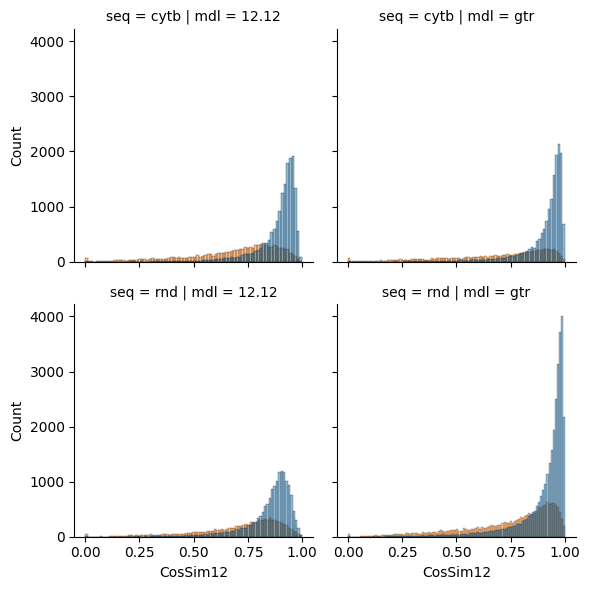

In [22]:
g = sns.FacetGrid(cossim12, col="mdl", row="seq")
g.map_dataframe(sns.histplot, x="CosSim12", hue="Label")

In [ ]:
# sns.catplot(
#     data=cossim12, col="mdl", row="seq", y="CosSim12", hue="Label",
#     kind="violin", split=False
# )

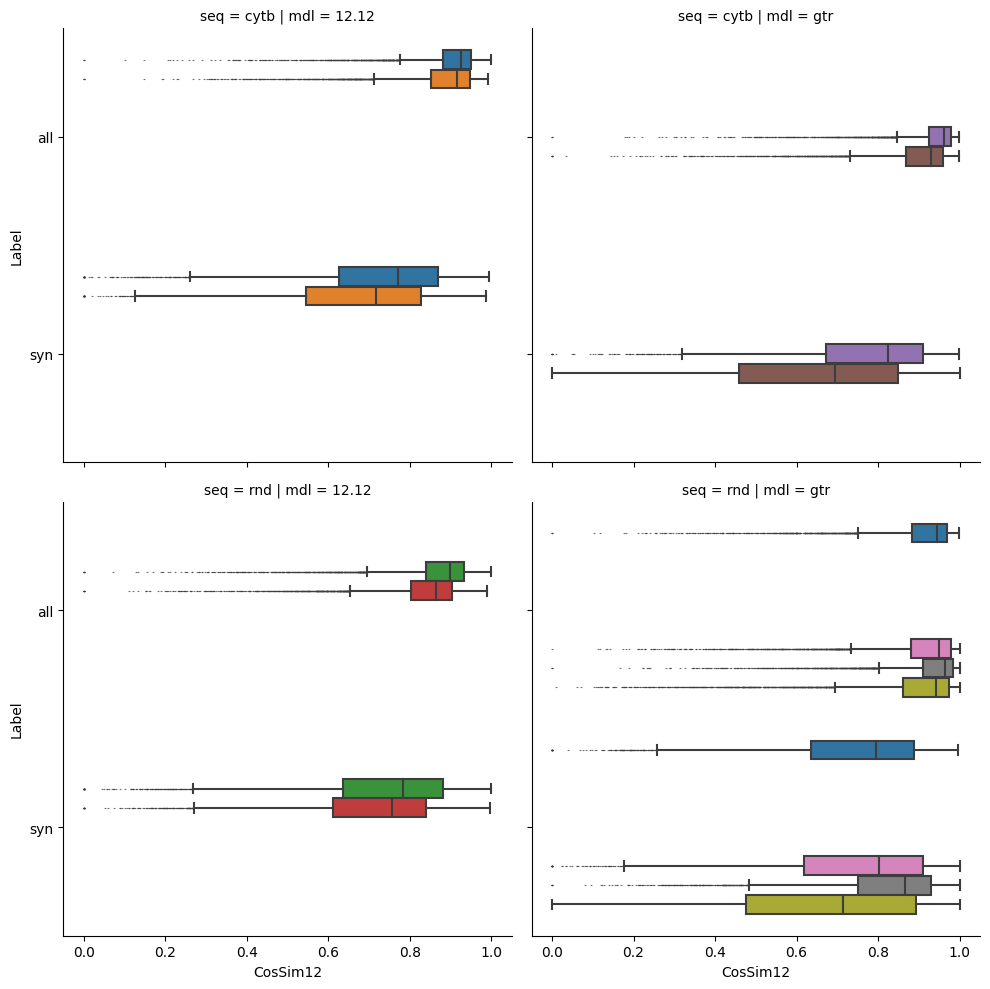

In [23]:
g = sns.catplot(data=cossim12, x="CosSim12", hue="replica", y="Label", col="mdl", row="seq", kind="box", fliersize=0.2, legend=False)

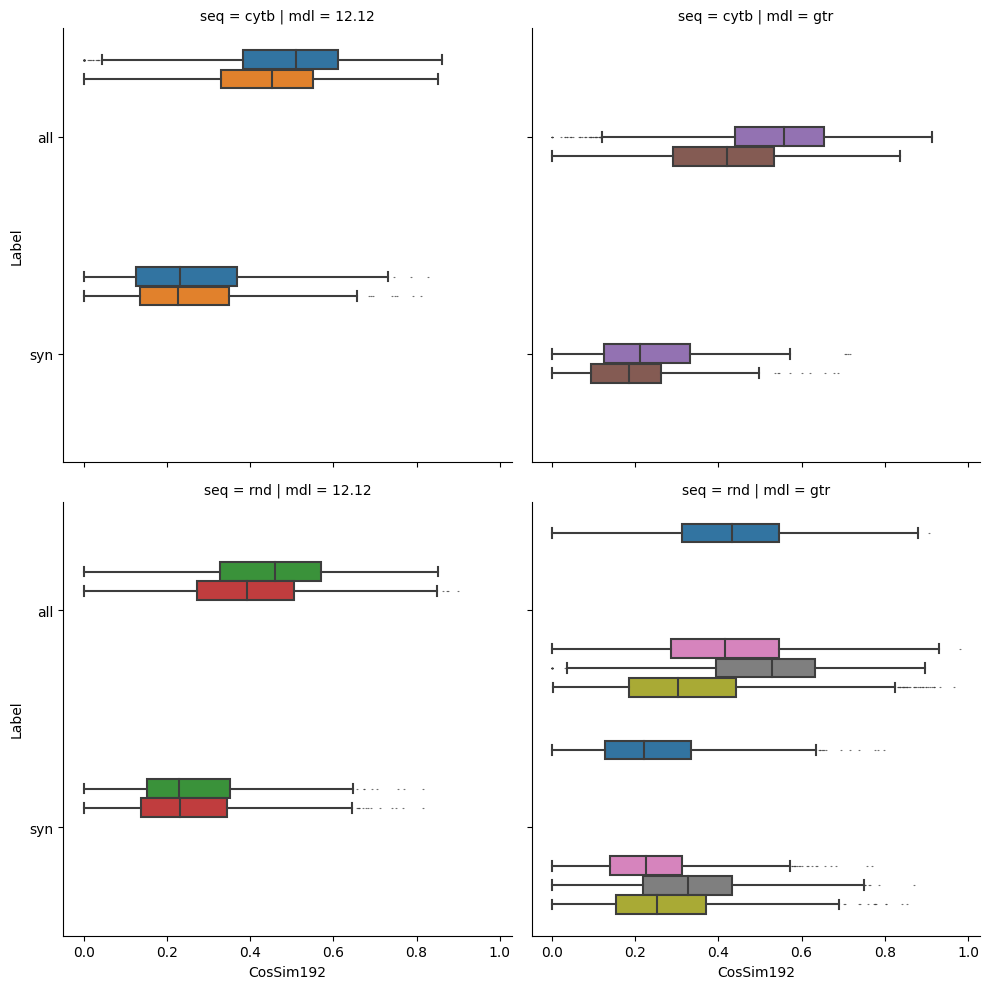

In [24]:
g = sns.catplot(data=cossim192, x="CosSim192", hue="replica", y="Label", col="mdl", row="seq", kind="box", fliersize=0.2, legend=False)

#### Compare OBS

In [ ]:
gt12_wide_obs = gt12.set_index(["RawCond", "Label", "AltNode", "Mut"]).ObsNum.unstack()
rec12_wide_obs = rec12.set_index(["RawCond", "Label", "AltNode", "Mut"]).ObsNum.unstack()
gt192_wide_obs = gt192.set_index(["RawCond", "Label", "AltNode", "Mut"]).ObsNum.unstack()
rec192_wide_obs = rec192.set_index(["RawCond", "Label", "AltNode", "Mut"]).ObsNum.unstack()

In [ ]:
# filter out edges with less than 16/4 mut types
gt12_wide_obs  = gt12_wide_obs[ (gt12_wide_obs > 0).sum(axis=1)  >= 4]
gt192_wide_obs = gt192_wide_obs[(gt192_wide_obs > 0).sum(axis=1) >= 16]

In [ ]:
cossim12 = get_cossim(gt12_wide_obs, rec12_wide_obs).rename("CosSim12").reset_index()
cossim192 = get_cossim(gt192_wide_obs, rec192_wide_obs).rename("CosSim192").reset_index()
cossim12

,RawCond,Label,AltNode,CosSim12
0,12.12_mam_cytb_replica_0,all,Node10,0.638682
1,12.12_mam_cytb_replica_0,all,Node100,0.931220
2,12.12_mam_cytb_replica_0,all,Node1001,0.982177
3,12.12_mam_cytb_replica_0,all,Node1002,0.896643
4,12.12_mam_cytb_replica_0,all,Node1003,0.617048
...,...,...,...,...
3024513,gtr_mam_rnd_replica_9,syn,RN_995,0.943510
3024514,gtr_mam_rnd_replica_9,syn,RN_996,0.999560
3024515,gtr_mam_rnd_replica_9,syn,RN_997,0.975544
3024516,gtr_mam_rnd_replica_9,syn,RN_998,0.958753


In [ ]:
cossim12["mdl"] = cossim12.RawCond.apply(lambda x: x.split("_")[0])
cossim12["seq"] = cossim12.RawCond.apply(lambda x: x.split("_")[2])
cossim12["replica"] = cossim12.RawCond.apply(lambda x: x.split("_")[-1])

cossim192["mdl"] = cossim192.RawCond.apply(lambda x: x.split("_")[0])
cossim192["seq"] = cossim192.RawCond.apply(lambda x: x.split("_")[2])
cossim192["replica"] = cossim192.RawCond.apply(lambda x: x.split("_")[-1])

In [ ]:
cossim12[(cossim12.mdl == "gtr") & (cossim12.seq == "rnd")]

,RawCond,Label,AltNode,CosSim12,mdl,seq,replica
2245249,gtr_mam_rnd_replica_0,all,Node10,0.634077,gtr,rnd,0
2245250,gtr_mam_rnd_replica_0,all,Node100,0.930359,gtr,rnd,0
2245251,gtr_mam_rnd_replica_0,all,Node1000,0.958769,gtr,rnd,0
2245252,gtr_mam_rnd_replica_0,all,Node1001,0.970820,gtr,rnd,0
2245253,gtr_mam_rnd_replica_0,all,Node1002,0.894427,gtr,rnd,0
...,...,...,...,...,...,...,...
3024513,gtr_mam_rnd_replica_9,syn,RN_995,0.943510,gtr,rnd,9
3024514,gtr_mam_rnd_replica_9,syn,RN_996,0.999560,gtr,rnd,9
3024515,gtr_mam_rnd_replica_9,syn,RN_997,0.975544,gtr,rnd,9
3024516,gtr_mam_rnd_replica_9,syn,RN_998,0.958753,gtr,rnd,9


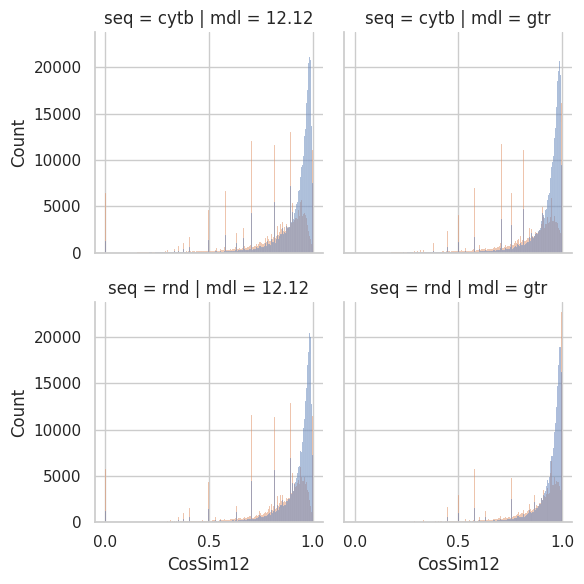

In [ ]:
g = sns.FacetGrid(cossim12, col="mdl", row="seq")
g.map_dataframe(sns.histplot, x="CosSim12", hue="Label")

In [ ]:
# sns.catplot(
#     data=cossim12, col="mdl", row="seq", y="CosSim12", hue="Label",
#     kind="violin", split=False
# )

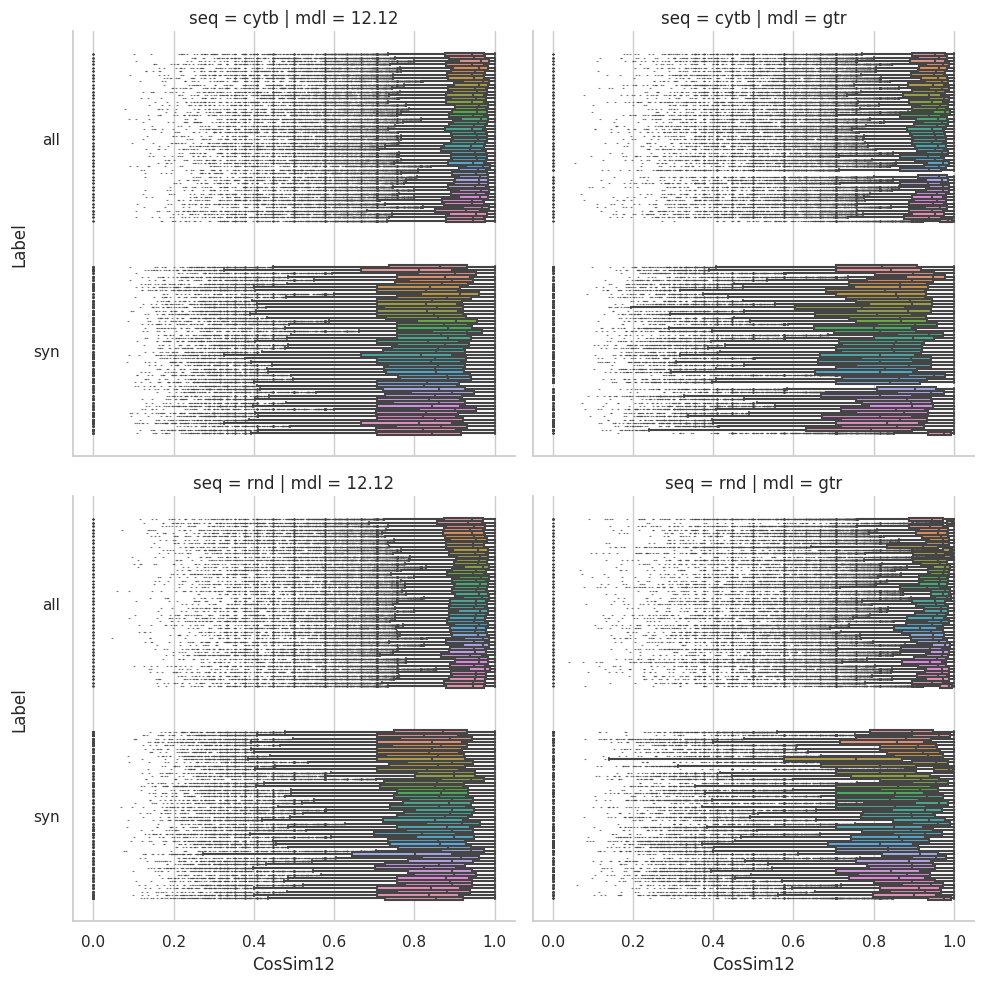

In [ ]:
g = sns.catplot(data=cossim12, x="CosSim12", hue="replica", y="Label", col="mdl", row="seq", kind="box", fliersize=0.2, legend=False)

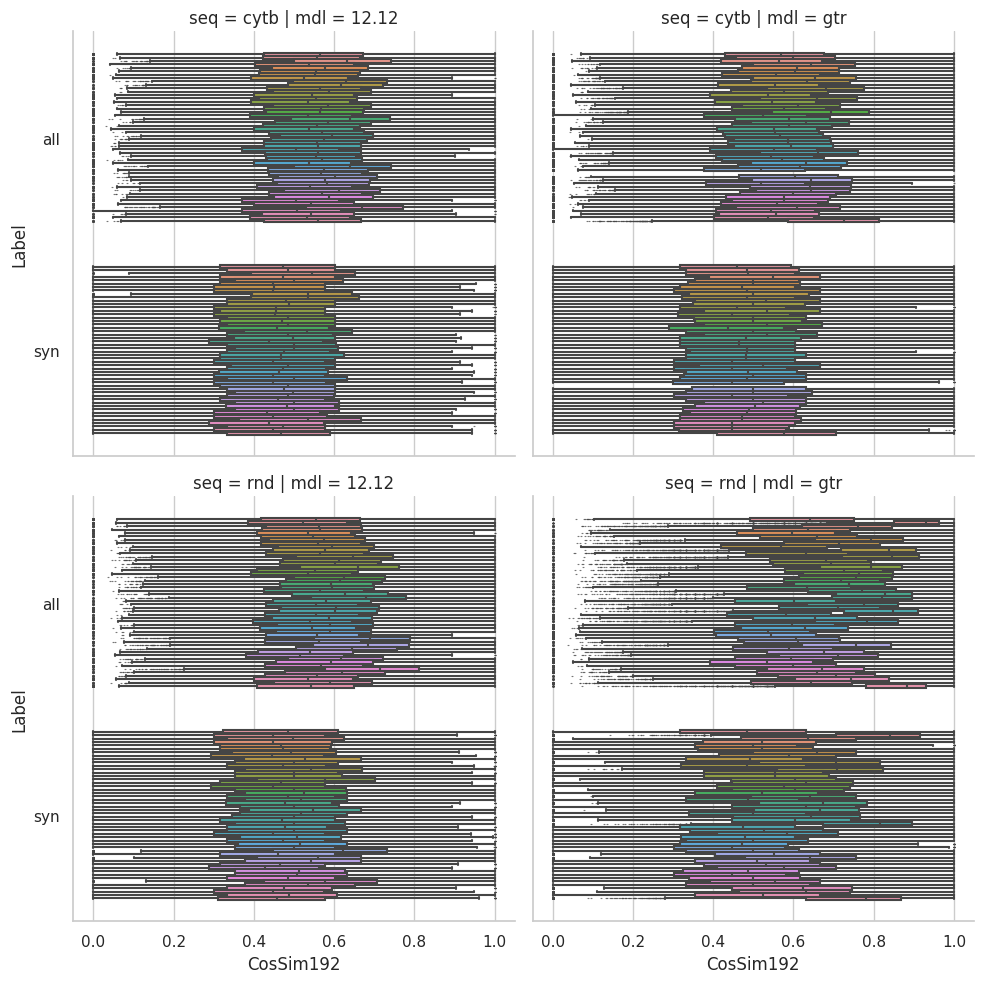

In [ ]:
g = sns.catplot(data=cossim192, x="CosSim192", hue="replica", y="Label", col="mdl", row="seq", kind="box", fliersize=0.2, legend=False)

## Mammals tree (low proba muts EXcluded)

### Preprocess data

In [4]:
data_rec12  = []
data_gt12   = []
data_rec192 = []
data_gt192  = []

colnames = ['Mut', 'ObsNum', 'ExpNum', 'MutSpec', 'AltNode', 'Label']
dtypes = {
    'ObsNum': np.float32,
    'ExpNum': np.float32,
    'MutSpec': np.float32,
}
i = 0

internal_mapping = {f"Node{x}":f"Node{x}" for x in range(5000)}
name2id = None
all_mappings = []

for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_mam/*")):
    i += 1
    cond = d.split("/")[-1]
    path_to_rec12  = os.path.join(d, "spectra_v2/mutspec12.tsv")
    path_to_rec192 = os.path.join(d, "spectra_v2/mutspec192.tsv")
    path_to_gt12   = f"../data/alisim/spectra_groundtruth_mam/{cond}/mutspec12.tsv"
    path_to_gt192  = f"../data/alisim/spectra_groundtruth_mam/{cond}/mutspec192.tsv"
    path_to_mapping = os.path.join(d, "sequences/species_mapping.txt")

    if os.path.exists(path_to_mapping):
        name2id_leaves = pd.read_csv(path_to_mapping, header=None, index_col=1, sep="\t")[0].to_dict()
        name2id = dict(**internal_mapping, **name2id_leaves)
        all_mappings.append(name2id)
    else:
        continue

    if os.path.exists(path_to_gt12) and os.path.exists(path_to_rec12):
        rec12  = pd.read_csv(path_to_rec12, sep="\t", usecols=colnames, dtype=dtypes).assign(RawCond=cond)
        gt12   = pd.read_csv(path_to_gt12,  sep="\t", usecols=colnames, dtype=dtypes).assign(RawCond=cond)
        # gt12["AltNode"] = gt12.AltNode.map(name2id)
        
        data_rec12.append(rec12)
        data_gt12.append(gt12)

    if os.path.exists(path_to_gt192) and os.path.exists(path_to_rec192):
        rec192 = pd.read_csv(path_to_rec192, sep="\t", usecols=colnames, dtype=dtypes).assign(RawCond=cond)
        gt192  = pd.read_csv(path_to_gt192,  sep="\t", usecols=colnames, dtype=dtypes).assign(RawCond=cond)
        # gt192["AltNode"] = gt192.AltNode.map(name2id)

        data_rec192.append(rec192)
        data_gt192.append(gt192)
    
    if i == 11:
        break


# check that all nodes names mappings are equal 
for x in all_mappings:
    assert x == all_mappings[0]


gt12   = pd.concat(data_gt12)
rec12  = pd.concat(data_rec12)
gt192  = pd.concat(data_gt192)
rec192 = pd.concat(data_rec192)

# replace encoded node names
gt12["AltNode"] = gt12.AltNode.map(name2id)
gt192["AltNode"] = gt192.AltNode.map(name2id)

  0%|          | 0/200 [00:00<?, ?it/s]

  5%|▌         | 10/200 [00:06<02:11,  1.45it/s]


In [5]:
gt12.head()

,Mut,ObsNum,ExpNum,MutSpec,AltNode,Label,RawCond
0,A>C,10.0,325.0,0.107685,OUTGRP,all,gtr_mam_cytb_replica_18
1,A>G,8.0,325.0,0.086148,OUTGRP,all,gtr_mam_cytb_replica_18
2,A>T,5.0,325.0,0.053842,OUTGRP,all,gtr_mam_cytb_replica_18
3,C>A,26.0,390.0,0.233318,OUTGRP,all,gtr_mam_cytb_replica_18
4,C>G,8.0,390.0,0.071790,OUTGRP,all,gtr_mam_cytb_replica_18


In [6]:
gt12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1230952 entries, 0 to 126731
Data columns (total 7 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   Mut      1230952 non-null  object 
 1   ObsNum   1230952 non-null  float32
 2   ExpNum   1230952 non-null  float32
 3   MutSpec  1230952 non-null  float32
 4   AltNode  1230952 non-null  object 
 5   Label    1230952 non-null  object 
 6   RawCond  1230952 non-null  object 
dtypes: float32(3), object(4)
memory usage: 61.0+ MB


In [7]:
gt192.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3141664 entries, 0 to 319359
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Mut      object 
 1   ObsNum   float32
 2   ExpNum   float32
 3   MutSpec  float32
 4   AltNode  object 
 5   Label    object 
 6   RawCond  object 
dtypes: float32(3), object(4)
memory usage: 155.8+ MB


In [8]:
#filter out low numbers of mutations
rec12 = rec12[(rec12.ObsNum > 1) & (rec12.ExpNum > 1)]
rec192 = rec192[(rec192.ObsNum > 1) & (rec192.ExpNum > 1)]

### Compare spectra

In [9]:
gt12_wide_spectra = gt12.set_index(["RawCond", "Label", "AltNode", "Mut"]).MutSpec.unstack()
rec12_wide_spectra = rec12.set_index(["RawCond", "Label", "AltNode", "Mut"]).MutSpec.unstack().fillna(0.)
gt192_wide_spectra = gt192.set_index(["RawCond", "Label", "AltNode", "Mut"]).MutSpec.unstack()
rec192_wide_spectra = rec192.set_index(["RawCond", "Label", "AltNode", "Mut"]).MutSpec.unstack().fillna(0.)

In [10]:
cossim12 = get_cossim(gt12_wide_spectra, rec12_wide_spectra).rename("CosSim12").reset_index()
cossim12["mdl"] = cossim12.RawCond.apply(lambda x: x.split("_")[0])
cossim12["seq"] = cossim12.RawCond.apply(lambda x: x.split("_")[2])
cossim12["replica"] = cossim12.RawCond.apply(lambda x: x.split("_")[-1])

cossim192 = get_cossim(gt192_wide_spectra, rec192_wide_spectra).rename("CosSim192").reset_index()
cossim192["mdl"] = cossim192.RawCond.apply(lambda x: x.split("_")[0])
cossim192["seq"] = cossim192.RawCond.apply(lambda x: x.split("_")[2])
cossim192["replica"] = cossim192.RawCond.apply(lambda x: x.split("_")[-1])

cossim12

,RawCond,Label,AltNode,CosSim12,mdl,seq,replica
0,12.12_mam_cytb_replica_4,all,Node10,0.187457,12.12,cytb,4
1,12.12_mam_cytb_replica_4,all,Node100,0.842592,12.12,cytb,4
2,12.12_mam_cytb_replica_4,all,Node1001,0.887035,12.12,cytb,4
3,12.12_mam_cytb_replica_4,all,Node1002,0.916852,12.12,cytb,4
4,12.12_mam_cytb_replica_4,all,Node1004,0.764602,12.12,cytb,4
...,...,...,...,...,...,...,...
150362,gtr_mam_rnd_replica_4,syn,RN_995,0.925538,gtr,rnd,4
150363,gtr_mam_rnd_replica_4,syn,RN_996,0.633807,gtr,rnd,4
150364,gtr_mam_rnd_replica_4,syn,RN_997,0.905296,gtr,rnd,4
150365,gtr_mam_rnd_replica_4,syn,RN_998,0.925362,gtr,rnd,4


In [18]:
cossim12.iloc[:, :-3].to_csv("../data/alisim/mam_cossim12.csv", index=False)
cossim192.iloc[:, :-3].to_csv("../data/alisim/mam_cossim192.csv", index=False)

#### Plot

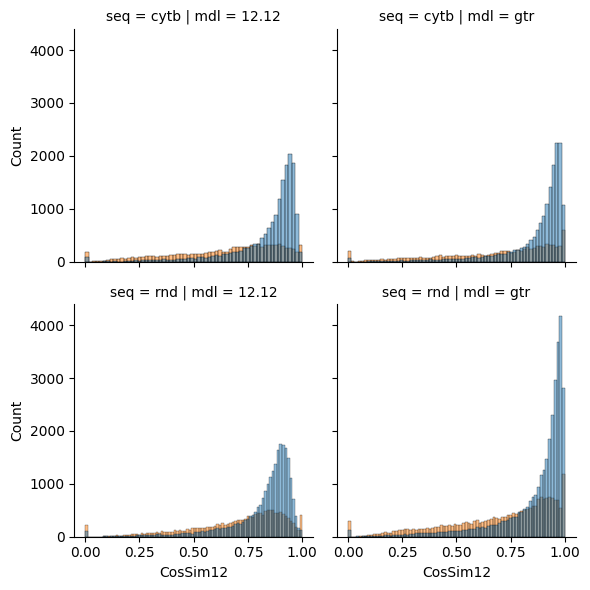

In [11]:
g = sns.FacetGrid(cossim12, col="mdl", row="seq")
g.map_dataframe(sns.histplot, x="CosSim12", hue="Label")

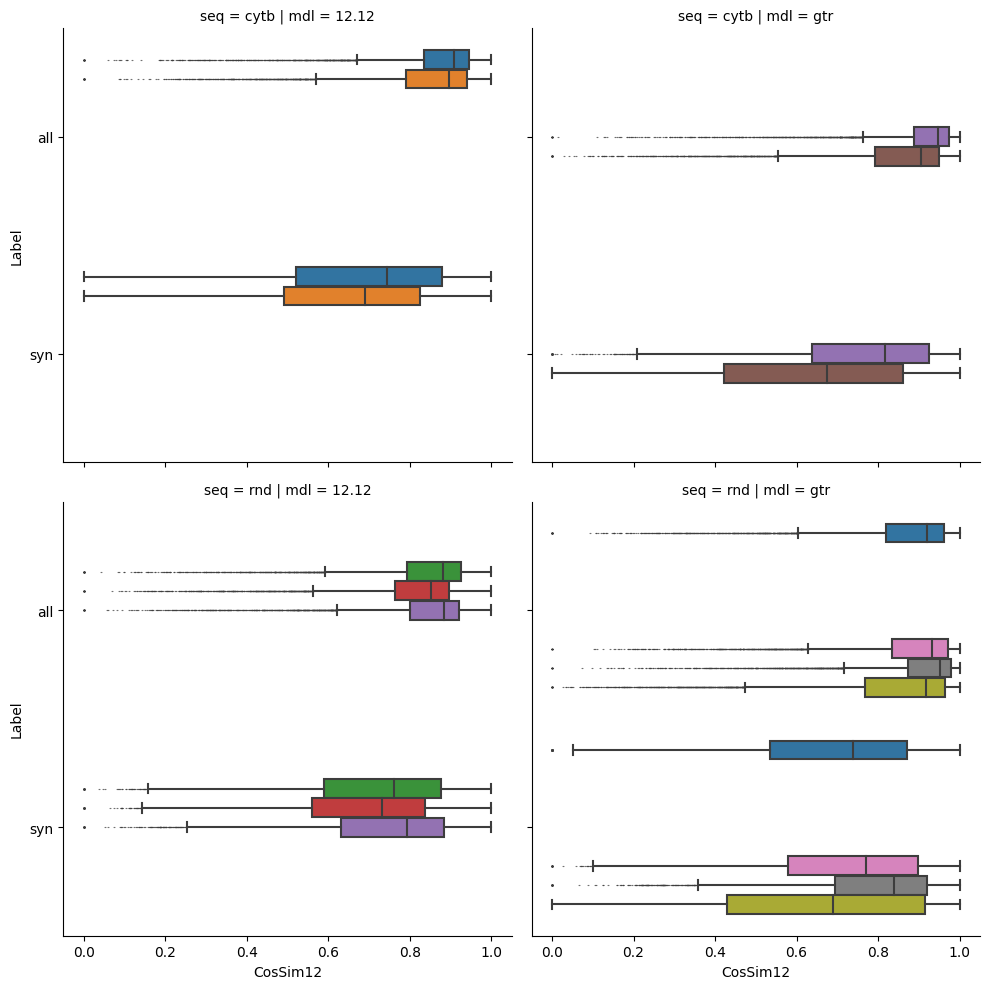

In [12]:
g = sns.catplot(
    data=cossim12, x="CosSim12", hue="replica", y="Label", col="mdl", row="seq", 
    kind="box", fliersize=0.2, legend=False)

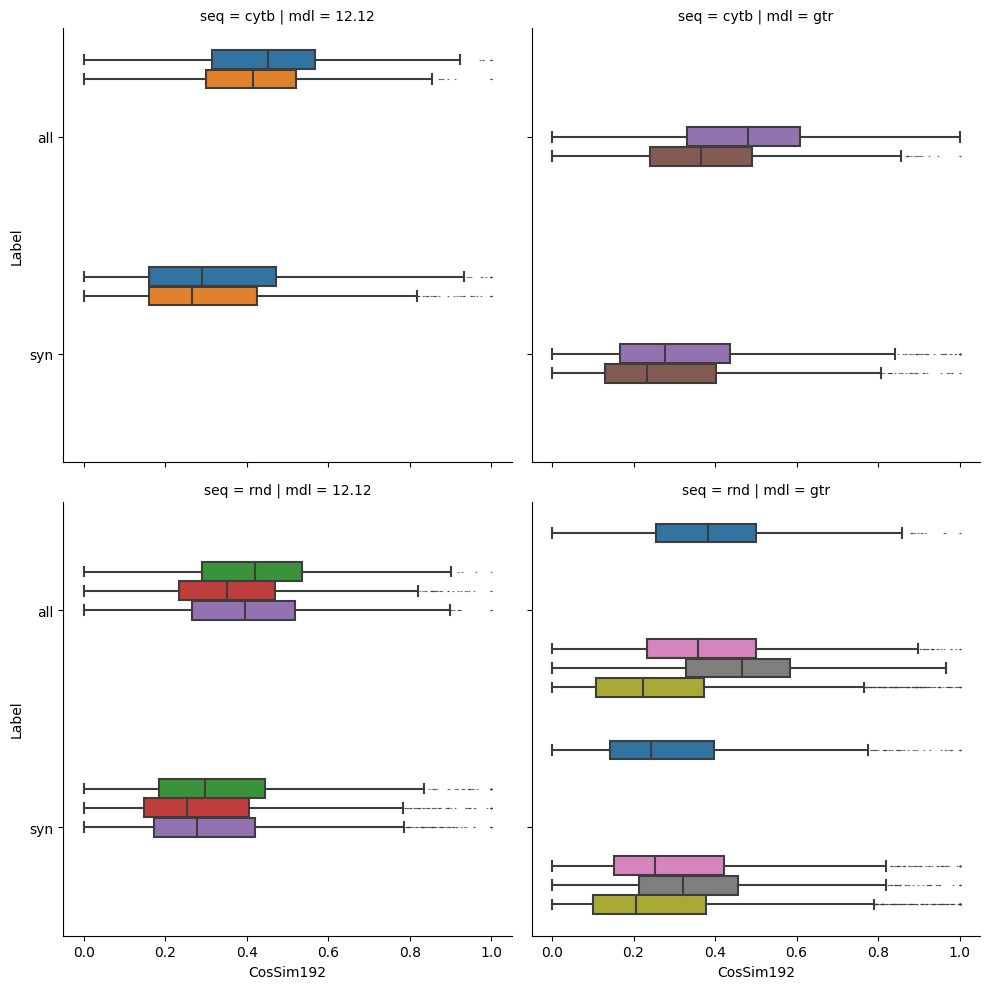

In [13]:
g = sns.catplot(
    data=cossim192, x="CosSim192", hue="replica", y="Label", col="mdl", row="seq", 
    kind="box", fliersize=0.2, legend=False)

In [ ]:
# filter out edges with less than 16/4 mut types
gt12_wide_spectra_filtered  = gt12_wide_spectra[ (gt12_wide_spectra > 0).sum(axis=1)  >= 4]
gt192_wide_spectra_filtered = gt192_wide_spectra[(gt192_wide_spectra > 0).sum(axis=1) >= 16]
rec12_wide_spectra_filtered  = rec12_wide_spectra[ (rec12_wide_spectra > 0).sum(axis=1)  >= 4]
rec192_wide_spectra_filtered = rec192_wide_spectra[(rec192_wide_spectra > 0).sum(axis=1) >= 16]

In [36]:
cossim12_filtered = get_cossim(gt12_wide_spectra_filtered, rec12_wide_spectra_filtered).rename("CosSim12").reset_index()
cossim12_filtered["mdl"] = cossim12_filtered.RawCond.apply(lambda x: x.split("_")[0])
cossim12_filtered["seq"] = cossim12_filtered.RawCond.apply(lambda x: x.split("_")[2])
cossim12_filtered["replica"] = cossim12_filtered.RawCond.apply(lambda x: x.split("_")[-1])

cossim192_filtered = get_cossim(gt192_wide_spectra_filtered, rec192_wide_spectra_filtered).rename("CosSim192").reset_index()
cossim192_filtered["mdl"] = cossim192_filtered.RawCond.apply(lambda x: x.split("_")[0])
cossim192_filtered["seq"] = cossim192_filtered.RawCond.apply(lambda x: x.split("_")[2])
cossim192_filtered["replica"] = cossim192_filtered.RawCond.apply(lambda x: x.split("_")[-1])

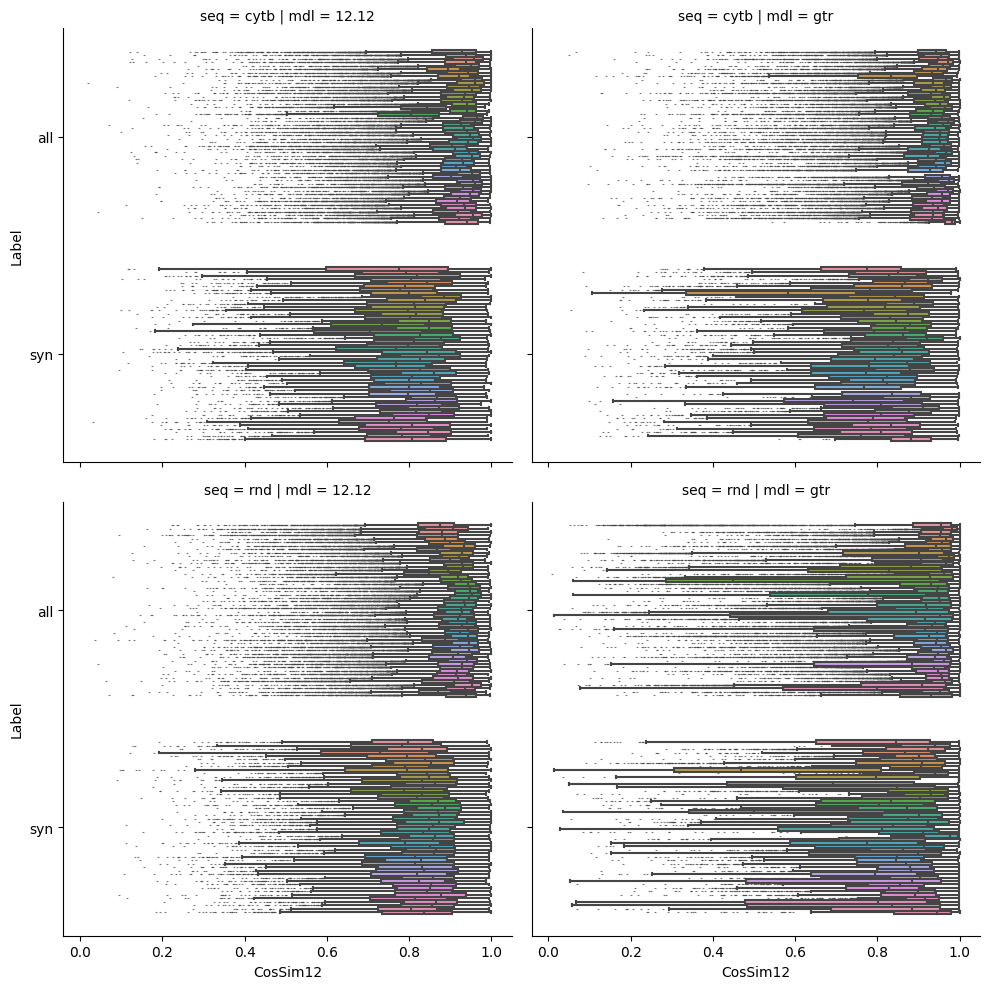

In [37]:
g = sns.catplot(
    data=cossim12_filtered, x="CosSim12", hue="replica", y="Label", col="mdl", row="seq", 
    kind="box", fliersize=0.2, legend=False)

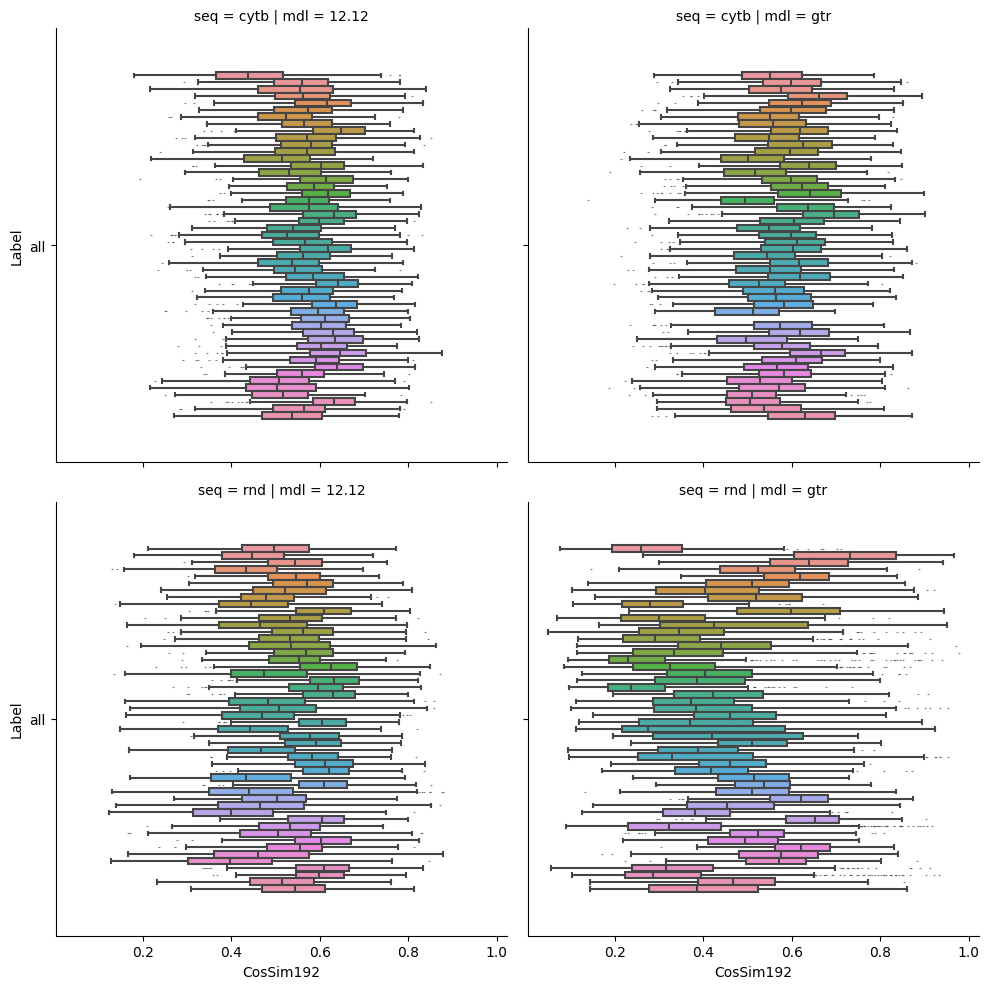

In [38]:
g = sns.catplot(
    data=cossim192_filtered, x="CosSim192", hue="replica", y="Label", col="mdl", row="seq", 
    kind="box", fliersize=0.2, legend=False)

#### Compare OBS

In [50]:
gt12_wide_obs = gt12.set_index(["RawCond", "Label", "AltNode", "Mut"]).ObsNum.unstack()
rec12_wide_obs = rec12.set_index(["RawCond", "Label", "AltNode", "Mut"]).ObsNum.unstack()
gt192_wide_obs = gt192.set_index(["RawCond", "Label", "AltNode", "Mut"]).ObsNum.unstack()
rec192_wide_obs = rec192.set_index(["RawCond", "Label", "AltNode", "Mut"]).ObsNum.unstack()

In [51]:
# filter out edges with less than 16/4 mut types
gt12_wide_obs_filtered  = gt12_wide_obs[ (gt12_wide_obs > 0).sum(axis=1)  >= 4]
gt192_wide_obs_filtered = gt192_wide_obs[(gt192_wide_obs > 0).sum(axis=1) >= 16]
rec12_wide_obs_filtered  = rec12_wide_obs[ (rec12_wide_obs > 0).sum(axis=1)  >= 4]
rec192_wide_obs_filtered = rec192_wide_obs[(rec192_wide_obs > 0).sum(axis=1) >= 16]

In [52]:
cossim12 = get_cossim(gt12_wide_obs, rec12_wide_obs).rename("CosSim12").reset_index()
cossim192 = get_cossim(gt192_wide_obs, rec192_wide_obs).rename("CosSim192").reset_index()

cossim12["mdl"] = cossim12.RawCond.apply(lambda x: x.split("_")[0])
cossim12["seq"] = cossim12.RawCond.apply(lambda x: x.split("_")[2])
cossim12["replica"] = cossim12.RawCond.apply(lambda x: x.split("_")[-1])

cossim192["mdl"] = cossim192.RawCond.apply(lambda x: x.split("_")[0])
cossim192["seq"] = cossim192.RawCond.apply(lambda x: x.split("_")[2])
cossim192["replica"] = cossim192.RawCond.apply(lambda x: x.split("_")[-1])

cossim12

,RawCond,Label,AltNode,CosSim12,mdl,seq,replica
0,12.12_mam_cytb_replica_0,all,Node10,0.499527,12.12,cytb,0
1,12.12_mam_cytb_replica_0,all,Node100,0.935969,12.12,cytb,0
2,12.12_mam_cytb_replica_0,all,Node1001,0.966555,12.12,cytb,0
3,12.12_mam_cytb_replica_0,all,Node1002,0.798830,12.12,cytb,0
4,12.12_mam_cytb_replica_0,all,Node1003,0.447214,12.12,cytb,0
...,...,...,...,...,...,...,...
2761887,gtr_mam_rnd_replica_9,syn,RN_995,0.948759,gtr,rnd,9
2761888,gtr_mam_rnd_replica_9,syn,RN_996,0.999292,gtr,rnd,9
2761889,gtr_mam_rnd_replica_9,syn,RN_997,0.976002,gtr,rnd,9
2761890,gtr_mam_rnd_replica_9,syn,RN_998,0.968973,gtr,rnd,9


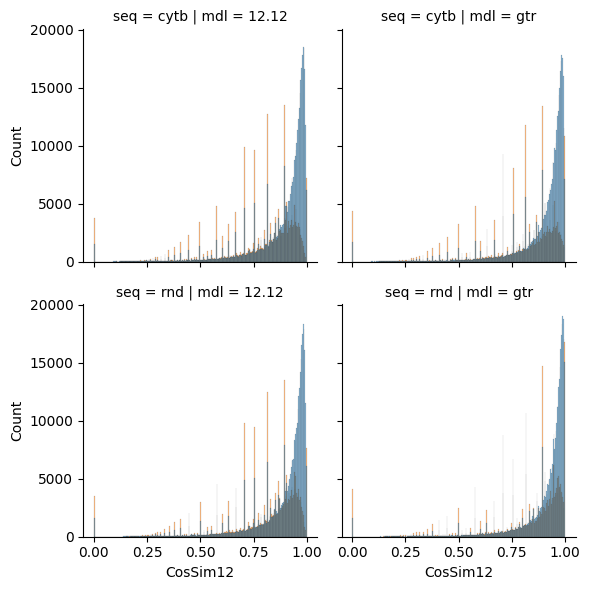

In [53]:
g = sns.FacetGrid(cossim12, col="mdl", row="seq")
g.map_dataframe(sns.histplot, x="CosSim12", hue="Label")

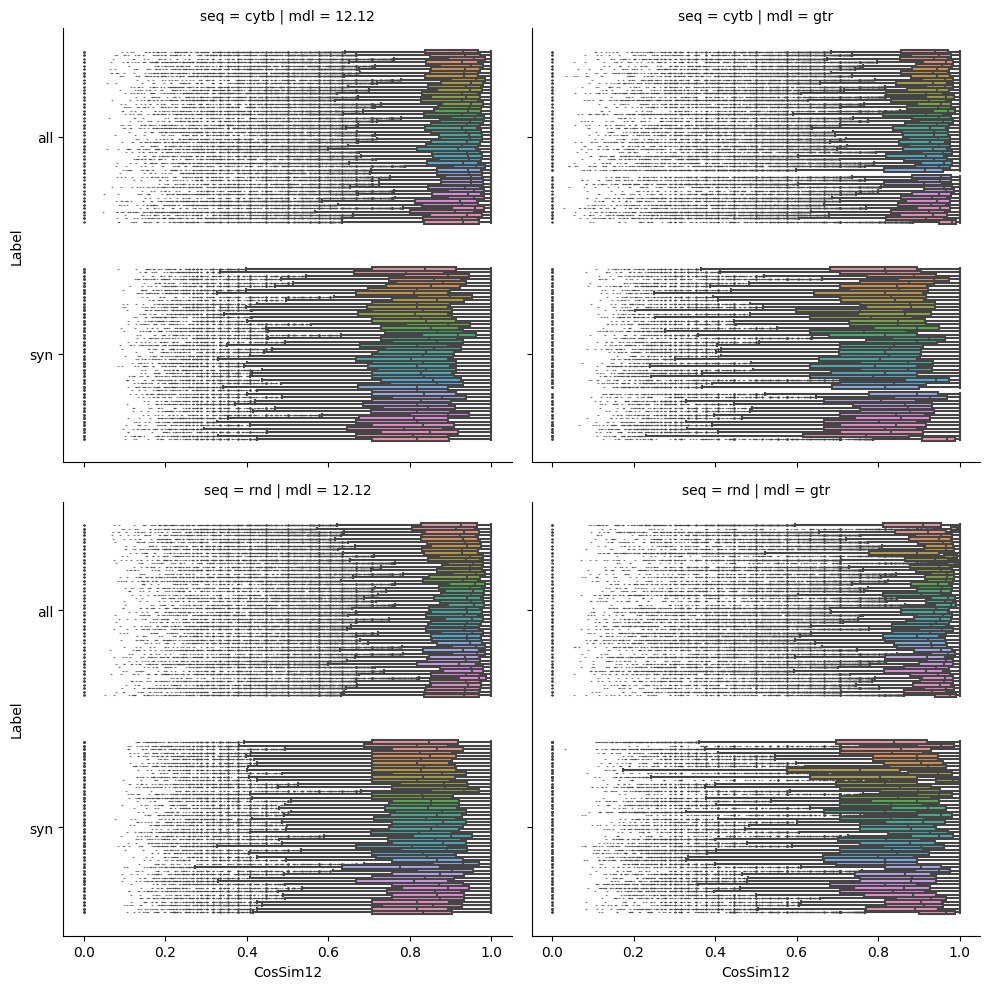

In [54]:
g = sns.catplot(data=cossim12, x="CosSim12", hue="replica", y="Label", col="mdl", row="seq", kind="box", fliersize=0.2, legend=False)

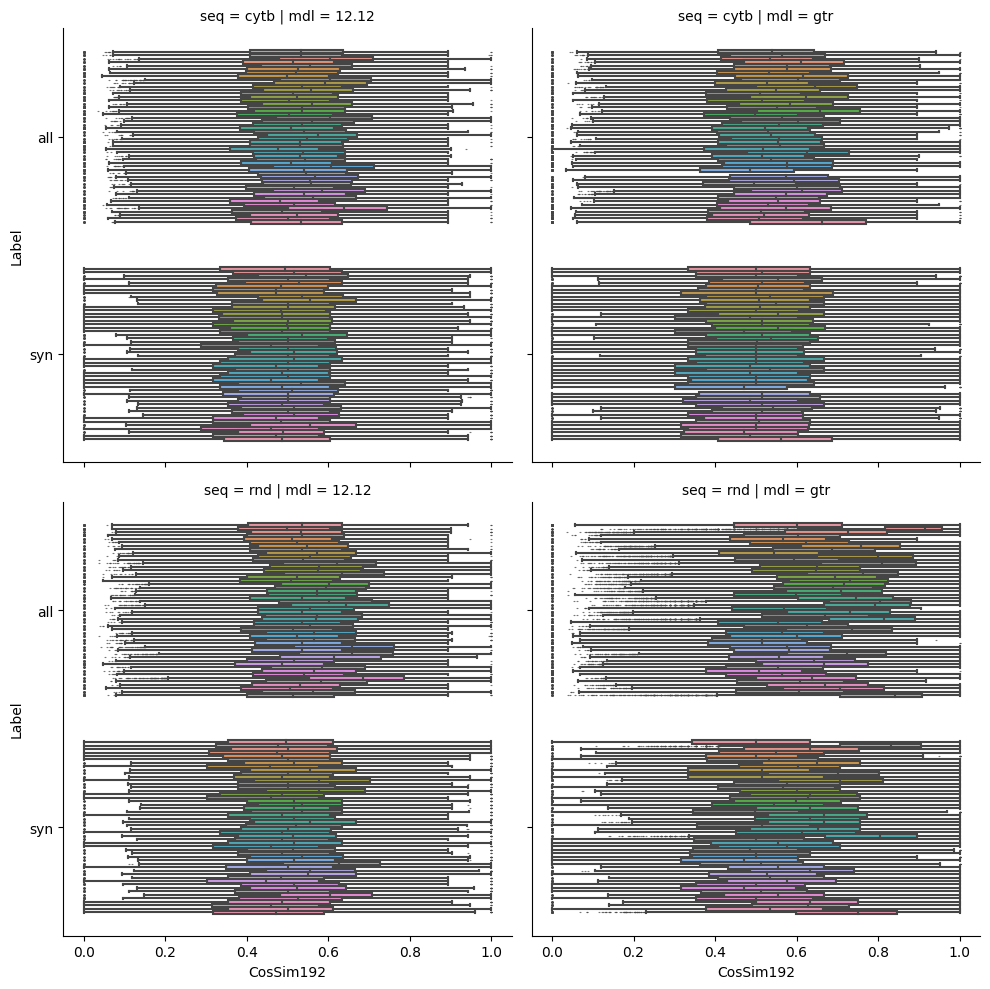

In [55]:
g = sns.catplot(data=cossim192, x="CosSim192", hue="replica", y="Label", col="mdl", row="seq", kind="box", fliersize=0.2, legend=False)

### Correlate edge cossim versus length